In [1]:
from sklearn import cluster, datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
def moons(n_samples, noise=0.1):
    """
    Generates moons from sklearn.datasets with n_samples samples
    """
    return datasets.make_moons(n_samples=n_samples, noise=noise, random_state=170)

def circles(n_samples, noise=0.1):
    """
    Generates concentric circles from sklearn.datasets with n_samples samples
    """
    return datasets.make_circles(n_samples=n_samples, noise=noise, random_state=170)

class DataSet(Dataset):
    def __init__(self, x_data, y_data):
        x_data = x_data.astype(np.float32)
        y_data = y_data.astype(np.int_)
        self.X = torch.from_numpy(x_data)
        self.Y = (torch.from_numpy(y_data)).type(torch.LongTensor)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]


In [3]:
class STNetwork(nn.Module):
    """
    Neural network that represents S and T functions in coupling layers
    """
    def __init__(self, num_inputs=2, num_outputs=2):
        super().__init__()
        self.hidden1 = 100
        self.hidden2 = 100
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, self.hidden1),
            nn.ReLU(),
            nn.Linear(self.hidden1, self.hidden2),
            nn.ReLU(),
            nn.Linear(self.hidden2, num_outputs)
        )

    def forward(self, x):
        return self.layers(x)
    
class CouplingLayer(nn.Module):
    def __init__(self, network, mask):
        super().__init__()
        self.network = network
        self.register_buffer("mask", mask)

    def forward(self, z, ldj, reverse=False):
        z_in = z * self.mask
        st = self.network(z_in)
        s, t = st.chunk(2, dim=1)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        if not reverse:
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=1)
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=1)

        return z, ldj

class Flow(nn.Module):
    def __init__(self, num_couplings, num_inputs=2):
        super().__init__()
        layer_list = []

        for i in range(num_couplings):
            layer_list.append( CouplingLayer(STNetwork(num_inputs=num_inputs, num_outputs=num_inputs), Flow.make_mask(num_inputs, i%2)) )

        self.layers = nn.ModuleList(layer_list)
    
    def forward(self, ins, reverse=False):
        z, ldj = ins, torch.zeros(ins.shape[0])
        for layer in reversed(self.layers) if reverse else self.layers:
            z, ldj = layer(z, ldj, reverse=reverse)

        return z, ldj
    
    def make_mask(size, pattern):
        mask = torch.tensor([(i+pattern)%2 for i in range(size)])
        return mask

def nll(z_in, ldj, z_dist: list, labels, num_classes=2):
    Classes = [[] for i in range(num_classes)]
    for i in range(len(labels)):
        Classes[int(labels[i])].append(i)

    log_qz = torch.tensor([])

    for i in range(num_classes):
        log_qz = torch.cat( (log_qz, z_dist[i].log_prob(z_in[Classes[i]])), 0)
    
    log_qx = ldj + log_qz
    nll = -log_qx
    nll = nll.mean()
    return nll

def predict(model, z_dist: list, inputs):
    z_out, _ = model(inputs, reverse=False)
    logprob = torch.stack( tuple([dist.log_prob(z_out) for dist in z_dist]) )
    return logprob.argmax(dim=0)

def NormalizingFlow(train_dataloader, test_dataloader, test_size, epochs=40, lr=1e-4, mean=4.0):

    z_dist0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([mean, 0.]), torch.eye(2))
    z_dist1 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([-mean, 0.]), torch.eye(2))
    z_dist = [z_dist0, z_dist1]
    model = Flow(num_couplings=5, num_inputs=2)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    Loss = []
    Accuracy = []
    for epoch in range(epochs):
        ### TRAINING
        model.train()
        for inputs, labels in train_dataloader:
            z, ldj = model(inputs, reverse=False)
            loss = nll(z, ldj, z_dist, labels)
            Loss.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        ### Accuracy
        model.eval()
        correct = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                    preds = predict(model, z_dist, inputs)
                    correct += (preds==labels).sum()
        Accuracy.append(correct/test_size)


    plt.plot([step for step in range(len(Loss))], Loss)
    plt.xlabel('Steps')
    plt.ylabel('Training Loss')
    plt.show()
    plt.plot([step for step in range(len(Accuracy))], Accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.show()
    print(max(Accuracy))

    return model, z_dist



In [4]:
class FNN(nn.Module):
    def __init__(self, num_ins=2, num_outs=2):
        super().__init__()
        self.hidden1 = 100
        self.hidden2 = 100
        self.classifier = nn.Sequential(
            nn.Linear(num_ins, self.hidden1),
            nn.ReLU(),
            nn.Linear(self.hidden1, self.hidden2),
            nn.ReLU(),
            nn.Linear(self.hidden2, num_outs),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.classifier(x)
        x = nn.functional.log_softmax(x)
        return x
    
def FNN3(train_dataloader, test_dataloader, test_size, epochs=40, lr=1e-4):
    model = FNN()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    Loss = []
    Accuracy = []
    for epoch in range(epochs):
        ### Training
        model.train()
        for inputs, labels in train_dataloader:
            outs = model(inputs)
            loss = criterion(outs, labels)
            Loss.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        ### Accuracy
        model.eval()
        correct = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                    outs = model(inputs)
                    preds = outs.argmax(dim=1)
                    correct += (preds==labels).sum()
        Accuracy.append(correct/test_size)


    plt.plot([step for step in range(len(Loss))], Loss)
    plt.xlabel('Steps')
    plt.ylabel('Training Loss')
    plt.show()
    plt.plot([step for step in range(len(Accuracy))], Accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.show()
    print(max(Accuracy))
    
    return model



In [5]:
batch_size = 128
num_samples, split = 10000, 8500

positions, Labels = moons(num_samples, noise=0.1)
training_data, test_data = DataSet(positions[:split], Labels[:split]), DataSet(positions[split:], Labels[split:])
train_dataloader, test_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True), DataLoader(test_data, batch_size=batch_size, shuffle=True)

POINTS = [
    torch.tensor( [[2., 0.25]] ),
    torch.tensor( [[-0.5, -0.5]] ),
    torch.tensor( [[0., 0.]] ),
    torch.tensor( [[1., -0.5]] )
] # Points for optimization

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_14148\2797395720.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(x)


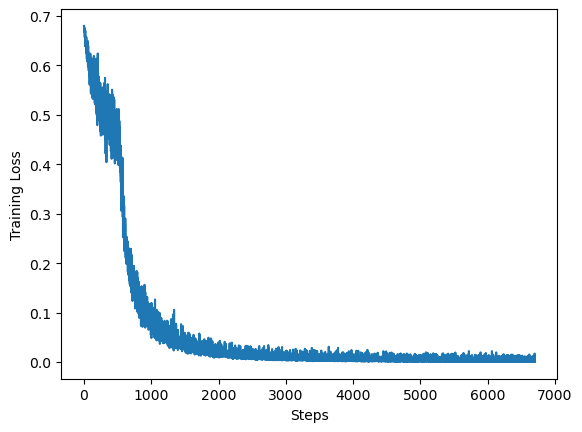

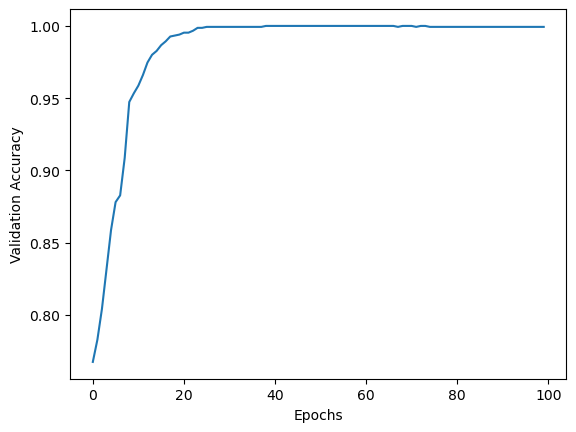

tensor(1.)


In [6]:
fnn = FNN3(train_dataloader=train_dataloader, test_dataloader=test_dataloader, test_size=len(test_data), epochs=100)

In [88]:
x = torch.nn.Parameter(POINTS[0].clone(), requires_grad=True)

x_optimizer = optim.Adam([x], lr = 0.1)

In [89]:
X = x.detach()

for i in range(11):
    y = fnn(x)
    loss = - y[0, 0]

    if torch.exp(-loss)>0.99:
        break

    x_optimizer.zero_grad()
    loss.backward()
    x_optimizer.step()

    X = torch.concat( (X, x.detach()))

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_21372\2797395720.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(x)


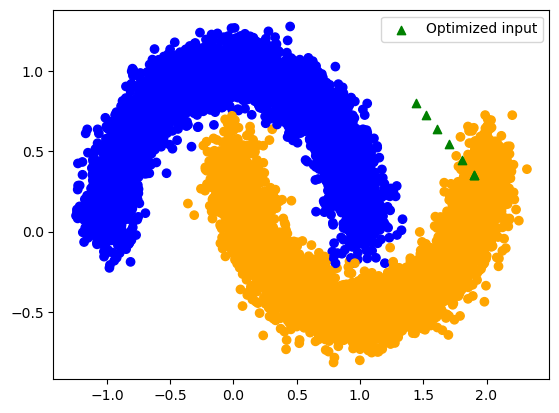

In [90]:
colors = np.array(['blue', 'orange'])
plt.scatter(positions[:, 0], positions[:, 1], color=colors[torch.tensor([int(i) for i in Labels])])
plt.scatter(X[:, 0], X[:, 1], marker='^', color='green', label='Optimized input')
plt.legend()
plt.show()

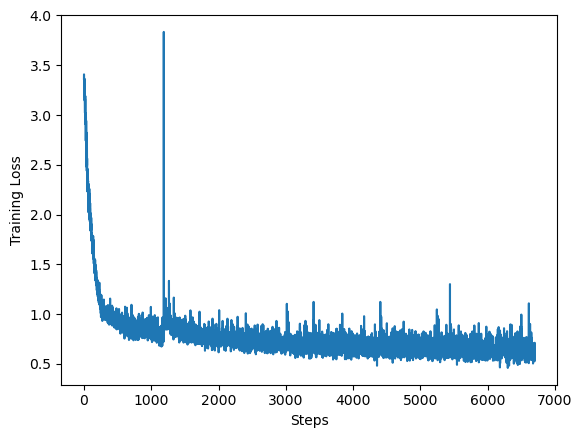

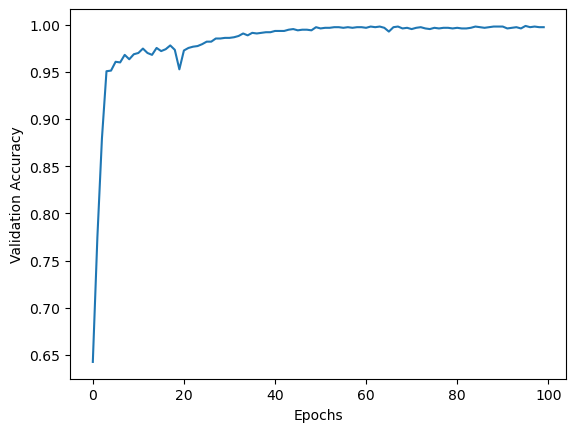

tensor(0.9987)


In [76]:
flow, z_dist = NormalizingFlow(train_dataloader=train_dataloader, test_dataloader=test_dataloader, test_size=len(test_data), epochs=100, mean=4.)

In [81]:
x = torch.nn.Parameter(POINTS[2].clone(), requires_grad=True)

x_optimizer = optim.Adam([x], lr = 0.1) 

In [82]:
X = x.detach()

for i in range(40):
    z_out, _ = flow(x, reverse=False)
    prob =  (torch.stack( tuple([dist.log_prob(z_out) for dist in z_dist]) ) )
    #print(prob[0, 0] / prob.sum())
    #loss = - prob[0,0] / prob.sum()
    loss = - prob[0, 0]

    if (z_out-torch.tensor([4, 0])).pow(2).sum().sqrt() < 1:
        print(i)
        break

    x_optimizer.zero_grad()
    loss.backward()
    x_optimizer.step()

    X = torch.concat( (X, x.detach()))

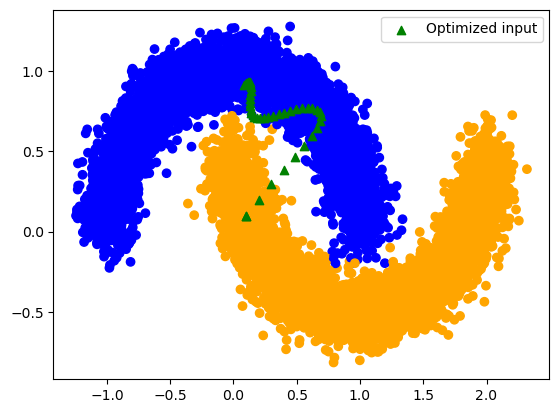

In [83]:
colors = np.array(['blue', 'orange'])
plt.scatter(positions[:, 0], positions[:, 1], color=colors[torch.tensor([int(i) for i in Labels])])
plt.scatter(X[:, 0], X[:, 1], marker='^', color='green', label='Optimized input')
plt.legend()
plt.show()

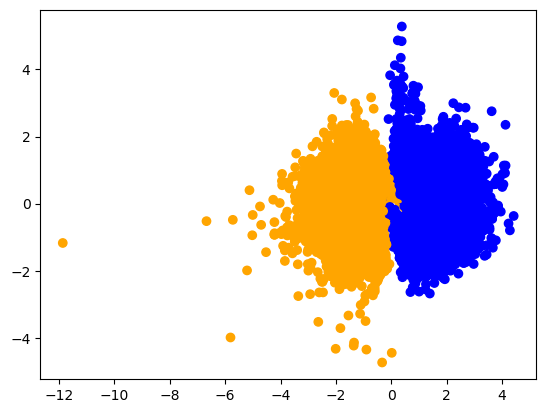

In [80]:
Positions = torch.from_numpy(positions.astype(np.float32))

z, ldj = flow(Positions, reverse=False)

colors = np.array(['blue', 'orange'])

predictions = predict(flow, z_dist, Positions) 
labels = torch.tensor([int(i) for i in Labels])

plt.scatter(z[:, 0].detach(), z[:, 1].detach(), color=colors[labels])
plt.show()

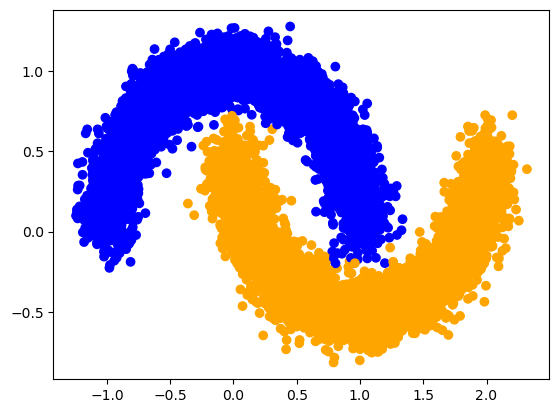

In [85]:
plt.scatter(Positions[:,0], Positions[:,1], color=colors[labels])
plt.show()

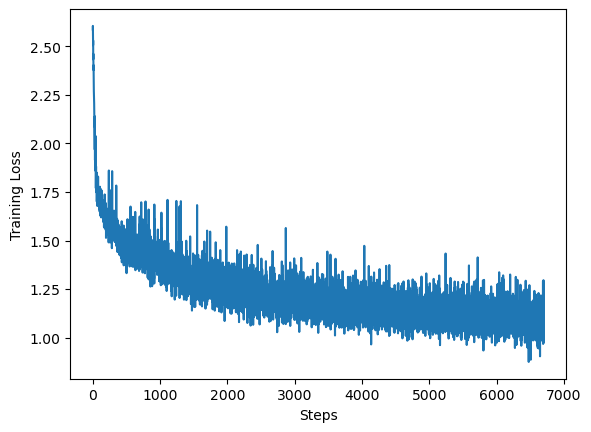

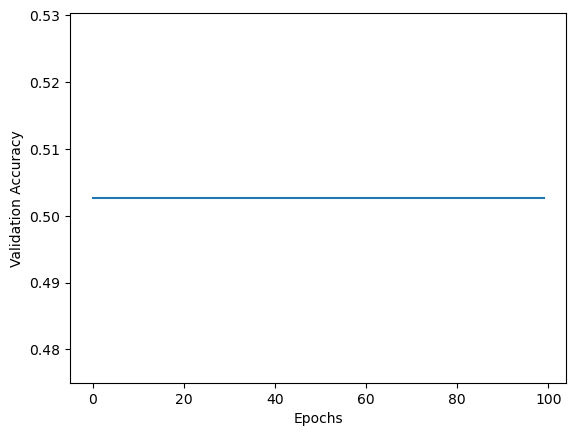

tensor(0.5027)


In [42]:
flow, z_dist = NormalizingFlow(train_dataloader=train_dataloader, test_dataloader=test_dataloader, test_size=len(test_data), epochs=100, mean=0.)

In [51]:
POINTS = [
    torch.tensor( [[2., 0.25]] ),
    torch.tensor( [[-0.5, -0.5]] ),
    torch.tensor( [[0., 0.]] ),
    torch.tensor( [[1., -0.5]] )
] # Points for optimization

In [71]:
x = torch.tensor(POINTS[2].clone())

z, _ = flow(x, reverse=False)

z = z.detach()

z.requires_grad = True

x_optimizer = optim.Adam([z], lr = 0.1)

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_14148\861491115.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(POINTS[2].clone())


In [72]:
Z = z.clone().detach()

for i in range(60):
    x, _ = flow(z, reverse=True)
    y = fnn(x)
    loss = - y[0, 0]

    if torch.exp(-loss)>0.99:
        print(torch.exp(-loss))
        break

    x_optimizer.zero_grad()
    loss.backward()
    x_optimizer.step()

    Z = torch.concat( (Z, z.clone().detach()))

tensor(0.9998, grad_fn=<ExpBackward0>)


C:\Users\Korisnik\AppData\Local\Temp\ipykernel_14148\2797395720.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(x)


In [73]:
X, _ = flow(Z, reverse=True)

In [74]:
X = X.detach()

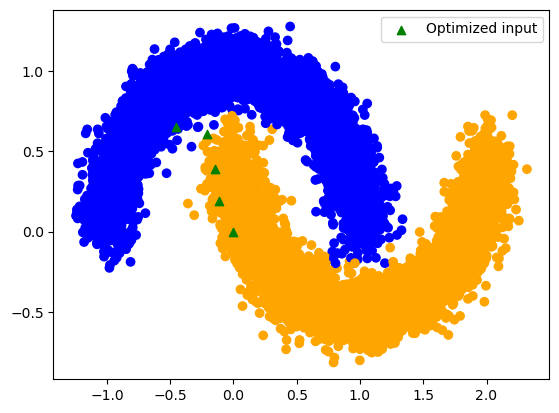

In [75]:
colors = np.array(['blue', 'orange'])
plt.scatter(positions[:, 0], positions[:, 1], color=colors[torch.tensor([int(i) for i in Labels])])
plt.scatter(X[:, 0], X[:, 1], marker='^', color='green', label='Optimized input')
plt.legend()
plt.show()

In [69]:
Z = Z.detach()

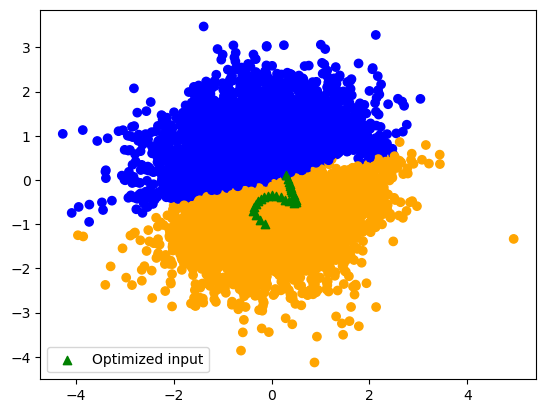

In [70]:
Positions = torch.from_numpy(positions.astype(np.float32))
pos, _ = flow(Positions, reverse=False)

pos = pos.detach()

colors = np.array(['blue', 'orange'])
plt.scatter(pos[:, 0], pos[:, 1], color=colors[torch.tensor([int(i) for i in Labels])])
plt.scatter(Z[:, 0], Z[:, 1], marker='^', color='green', label='Optimized input')
plt.legend()
plt.show()